In [0]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib import style
from sklearn.decomposition import PCA
import matplotlib.cm as cm
from sklearn.preprocessing import PolynomialFeatures
from matplotlib import *

In [4]:
kc_df = pd.read_csv('https://raw.githubusercontent.com/jiadai777/predict-housing-price-project/master/kc_house_data.csv')
kc_df.head()

id             date     price  ...     long  sqft_living15  sqft_lot15
0  7129300520  20141013T000000  221900.0  ... -122.257           1340        5650
1  6414100192  20141209T000000  538000.0  ... -122.319           1690        7639
2  5631500400  20150225T000000  180000.0  ... -122.233           2720        8062
3  2487200875  20141209T000000  604000.0  ... -122.393           1360        5000
4  1954400510  20150218T000000  510000.0  ... -122.045           1800        7503

[5 rows x 21 columns]

In [5]:
list(kc_df.columns.values)

['id',
 'date',
 'price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

Downtown Seatle location: 47.609203, -122.333134

Define a function to calculate the distance between two long-lat points on Earth.

In [0]:
def get_distance(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))

Calculate the distance between the house and Downtown Seatle, and add the distance data as a new column to the data frame

In [9]:
distances = []
for index, row in kc_df.iterrows():
    distance = get_distance(row['lat'], row['long'], 47.609203, -122.333134)
    distances.append(distance)
kc_df.insert(19, "DtoDTS", distances)
kc_df.head()

id             date     price  ...     DtoDTS  sqft_living15  sqft_lot15
0  7129300520  20141013T000000  221900.0  ...  12.304068           1340        5650
1  6414100192  20141209T000000  538000.0  ...  12.476237           1690        7639
2  5631500400  20150225T000000  180000.0  ...  16.155487           2720        8062
3  2487200875  20141209T000000  604000.0  ...  10.807568           1360        5000
4  1954400510  20150218T000000  510000.0  ...  21.615132           1800        7503

[5 rows x 22 columns]

There are houses with bedrooms of 33 and 0. Upon investigation using street view feature on Google Maps, it looks like the 33 bedrooms house is in single houses area, and the 0 bedroom houses are either vacant lands or destroyed. Therefore, these data will be dropped.

In [0]:
kc_df = kc_df[(kc_df.bedrooms > 0) & (kc_df.bedrooms < 33)]

Drop id as we do not need it in our prediction model.

In [16]:
kc_df = kc_df.drop(['id'], axis=1)
kc_df.head()

date     price  bedrooms  ...     DtoDTS  sqft_living15  sqft_lot15
0  20141013T000000  221900.0         3  ...  12.304068           1340        5650
1  20141209T000000  538000.0         3  ...  12.476237           1690        7639
2  20150225T000000  180000.0         2  ...  16.155487           2720        8062
3  20141209T000000  604000.0         4  ...  10.807568           1360        5000
4  20150218T000000  510000.0         3  ...  21.615132           1800        7503

[5 rows x 21 columns]

In [0]:
features = ['bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view','condition','grade','sqft_above','sqft_basement','yr_built','yr_renovated','zipcode','lat','long','sqft_living15','sqft_lot15', 'DtoDTS']

In [23]:
feature_matrix = kc_df[features]
feature_matrix_unscaled = kc_df[features]
lable_vector = kc_df['price']
feature_matrix_unscaled.head()

bedrooms  bathrooms  sqft_living  ...  sqft_living15  sqft_lot15     DtoDTS
0         3       1.00         1180  ...           1340        5650  12.304068
1         3       2.25         2570  ...           1690        7639  12.476237
2         2       1.00          770  ...           2720        8062  16.155487
3         4       3.00         1960  ...           1360        5000  10.807568
4         3       2.00         1680  ...           1800        7503  21.615132

[5 rows x 19 columns]

Correlation using Heatmap

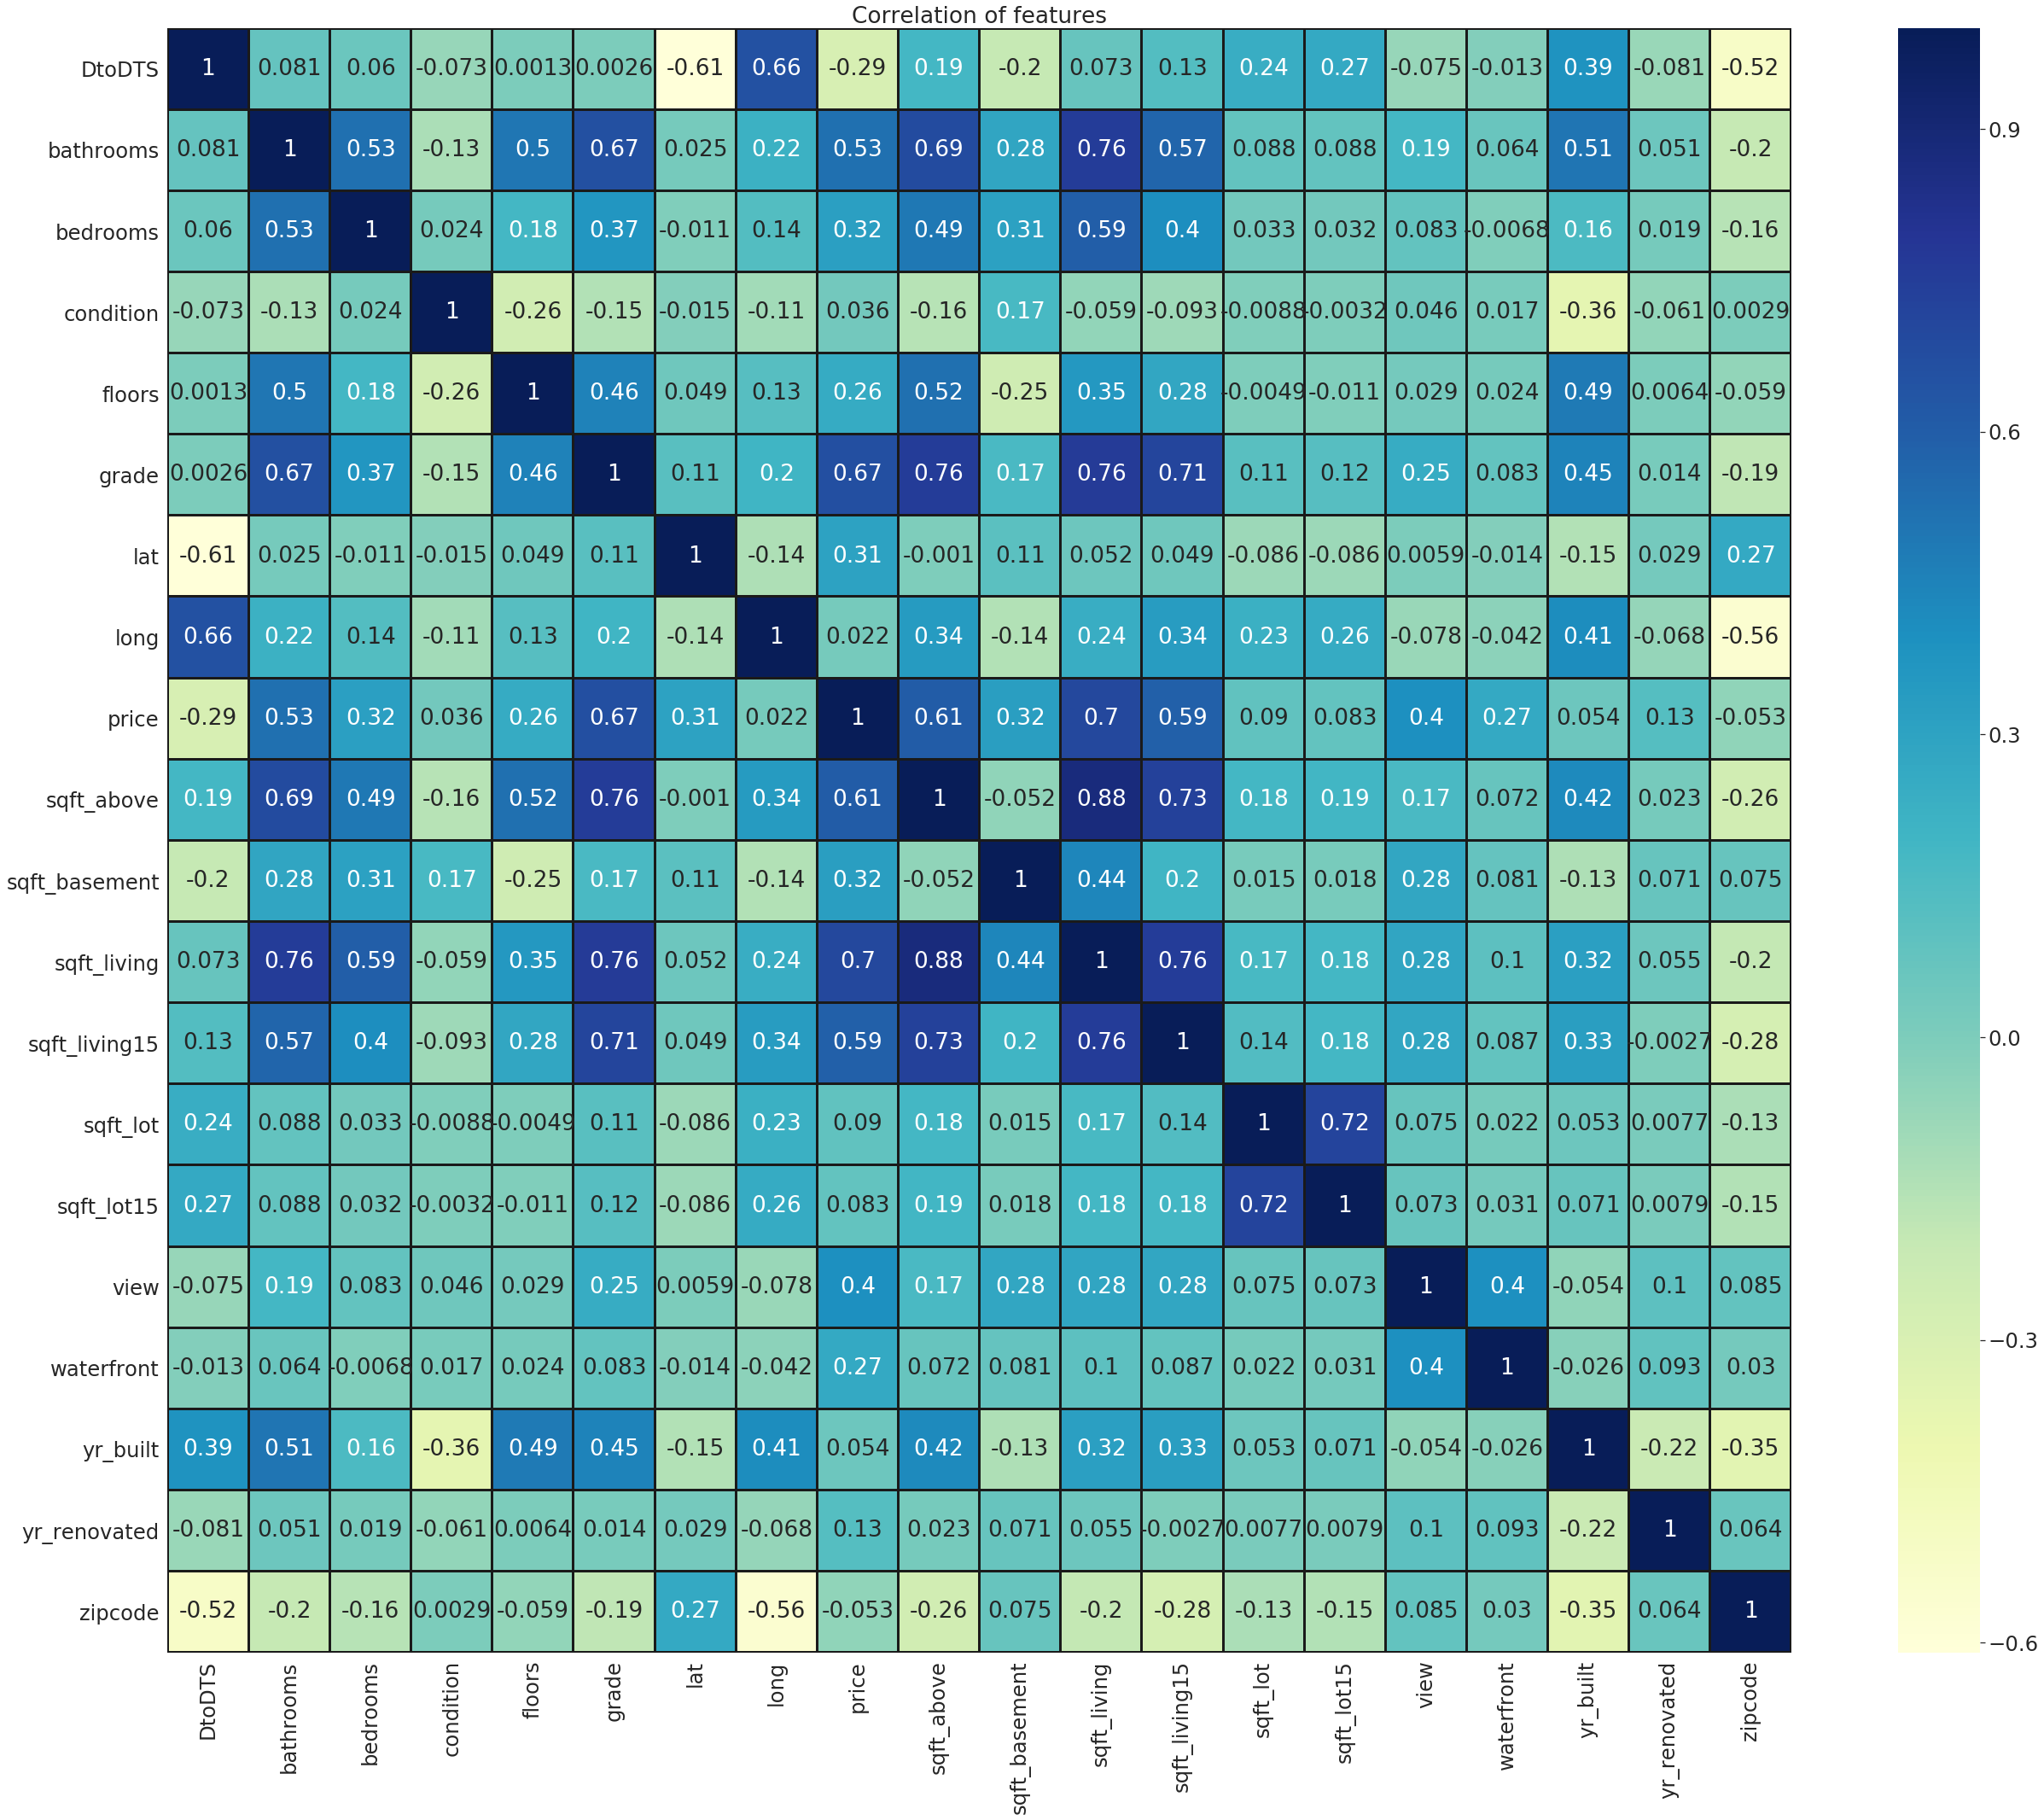

In [17]:
sns.set(font_scale=2.2)
str_list = [] # empty list to contain columns with strings (words)
for colname, colvalue in kc_df.iteritems():
   if type(colvalue[1]) == str:
        str_list.append(colname)
# Get to the numeric columns by inversion            
num_list = kc_df.columns.difference(str_list) 
# Create Dataframe containing only numerical features
house_num = kc_df[num_list]
f, ax = plt.subplots(figsize=(45, 35))
plt.title('Correlation of features')
# Draw the heatmap using seaborn
#sns.heatmap(house_num.astype(float).corr(),linewidths=0.25,vmax=1.0, square=True, cmap="PuBuGn", linecolor='k', annot=True)
sns.heatmap(house_num.astype(float).corr(),linewidths=2.0,vmax=1.0, square=True, cmap="YlGnBu", linecolor='k', annot=True)
plt.show()

Getting insight of data using scatter plot (Feature vs Price)

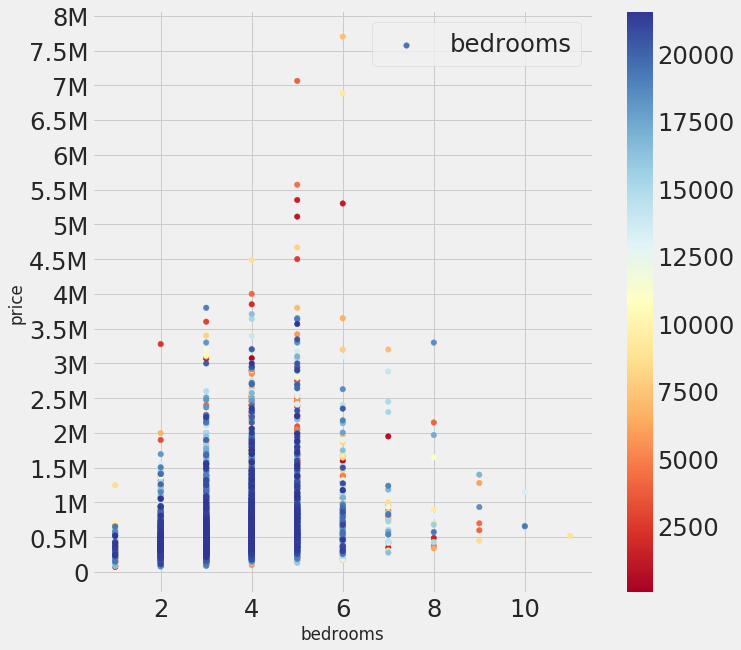

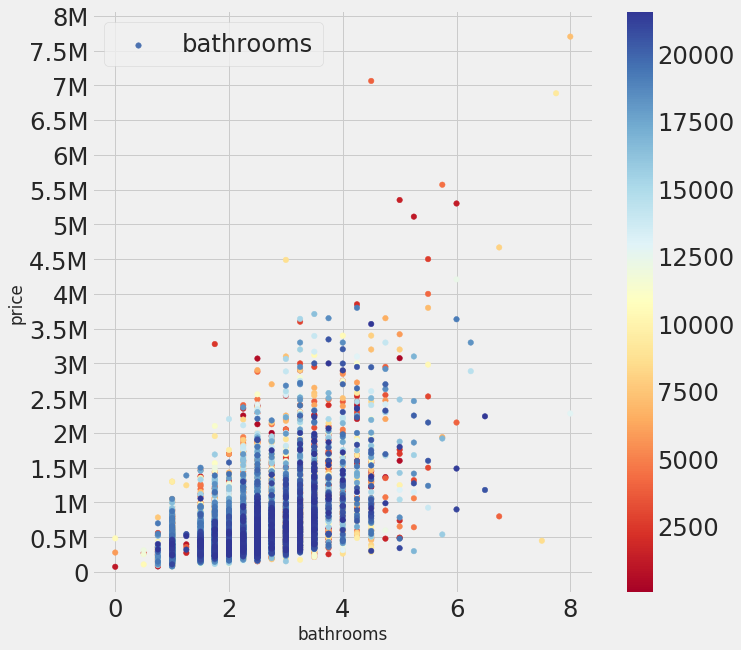

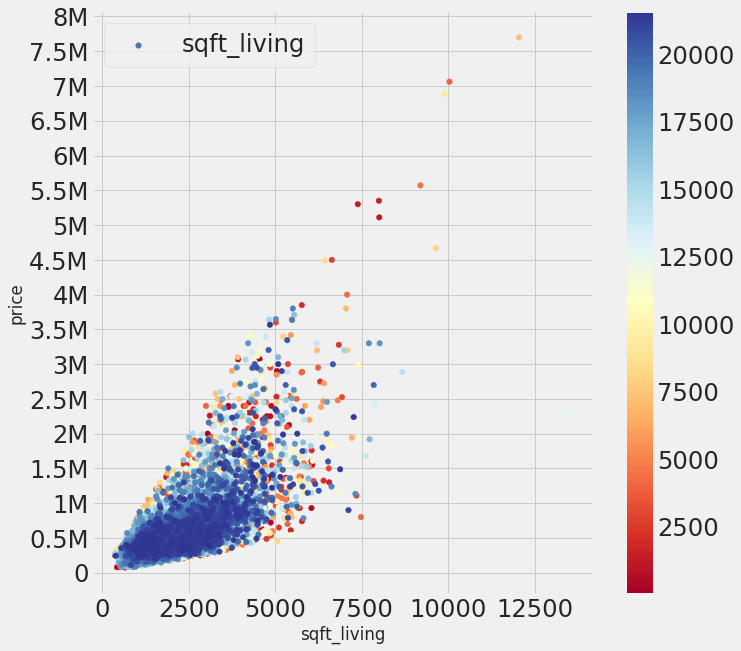

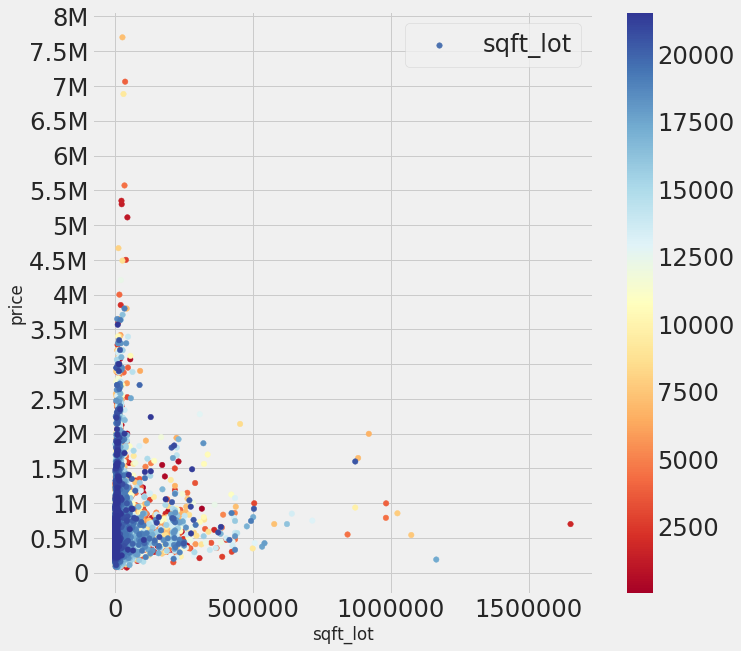

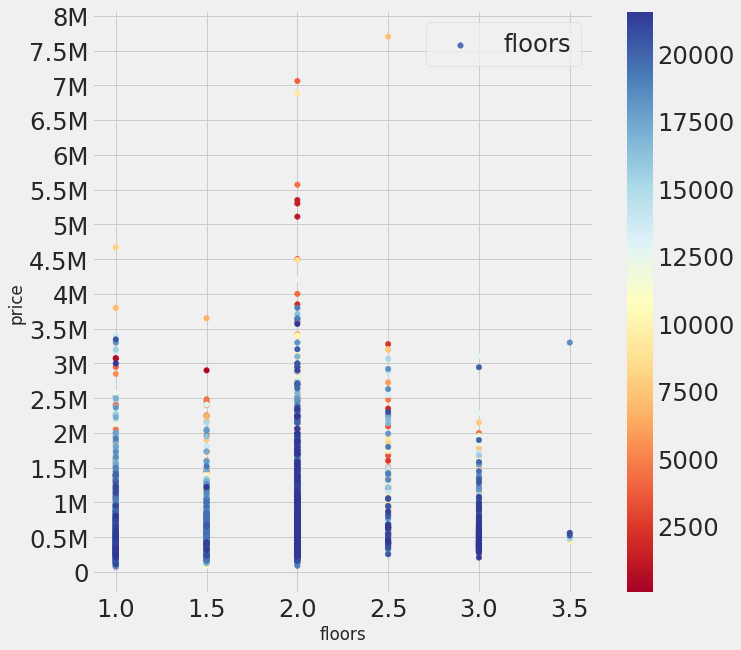

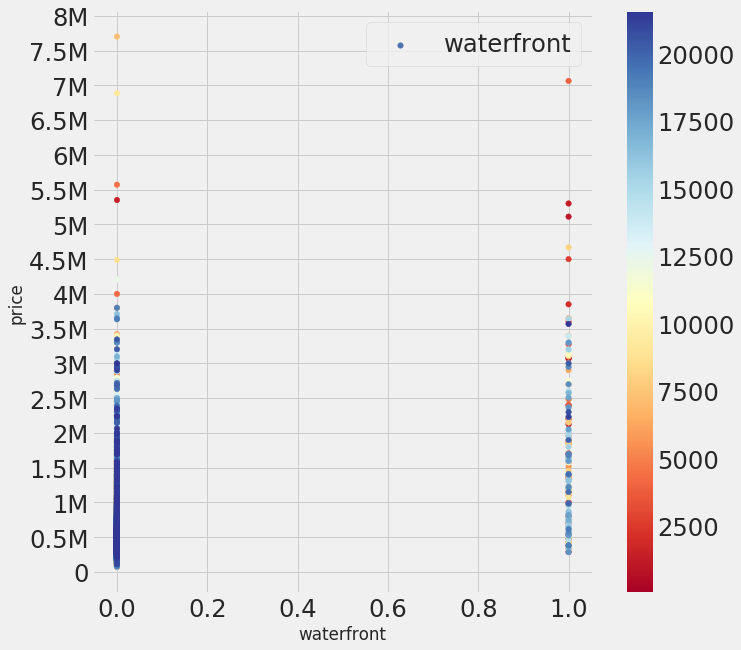

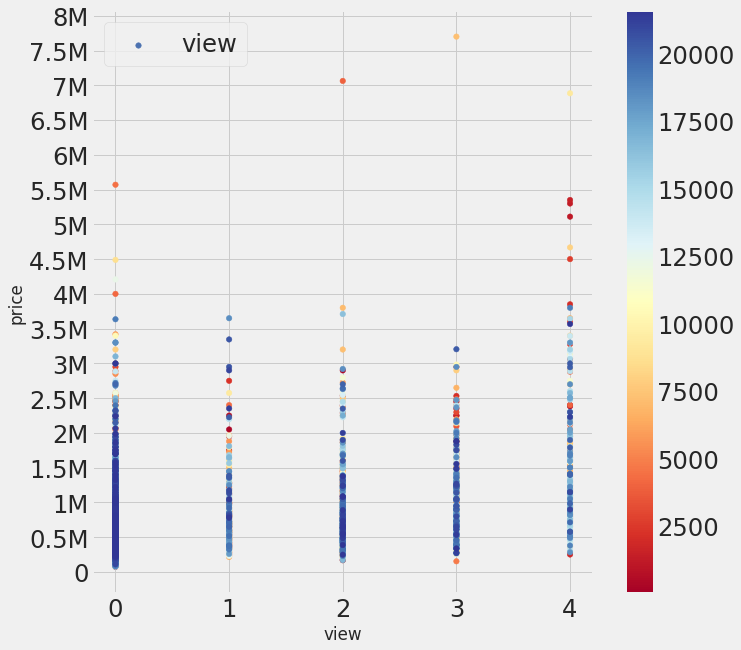

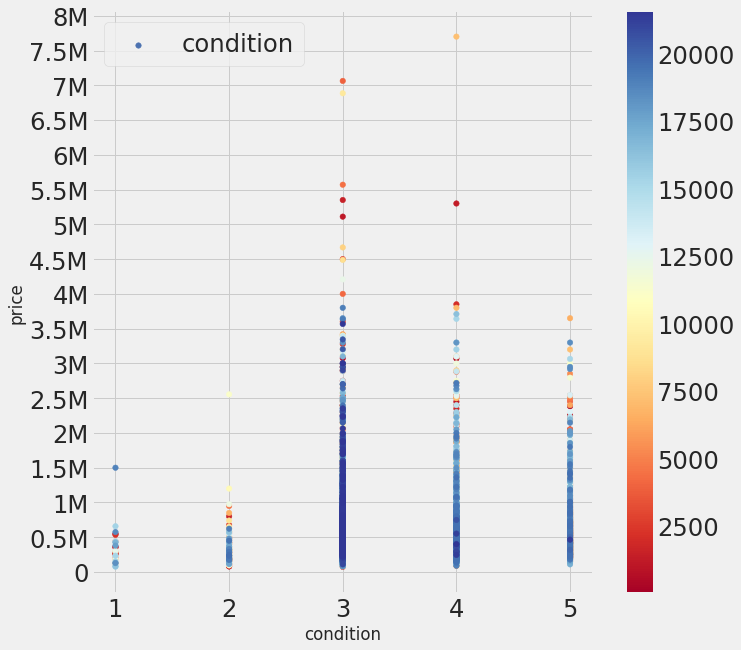

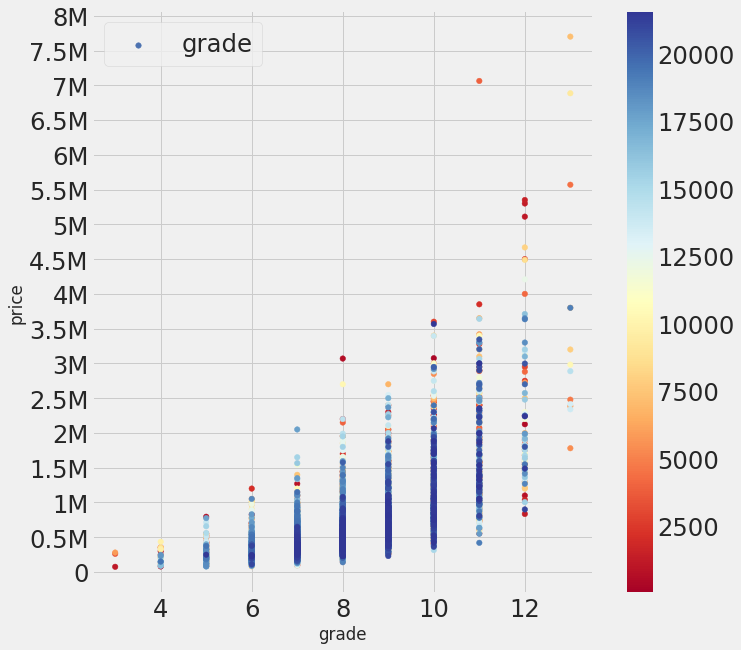

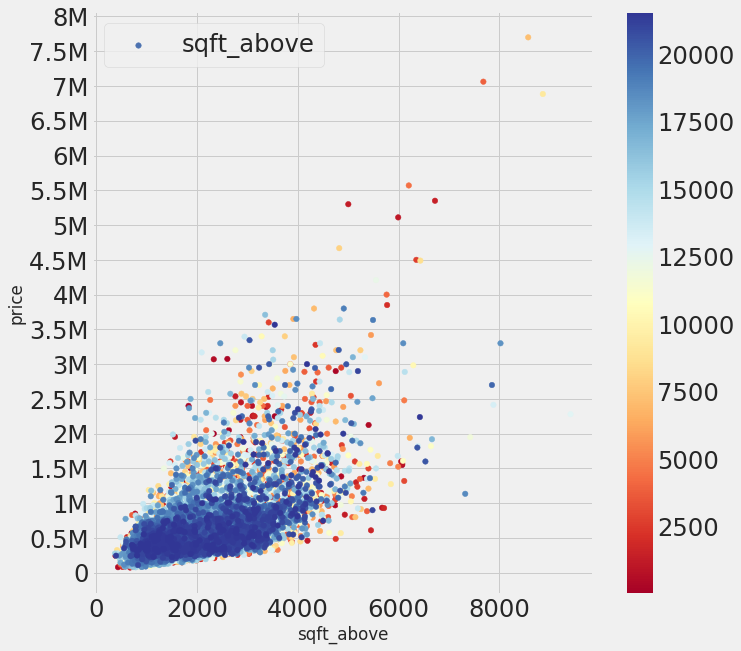

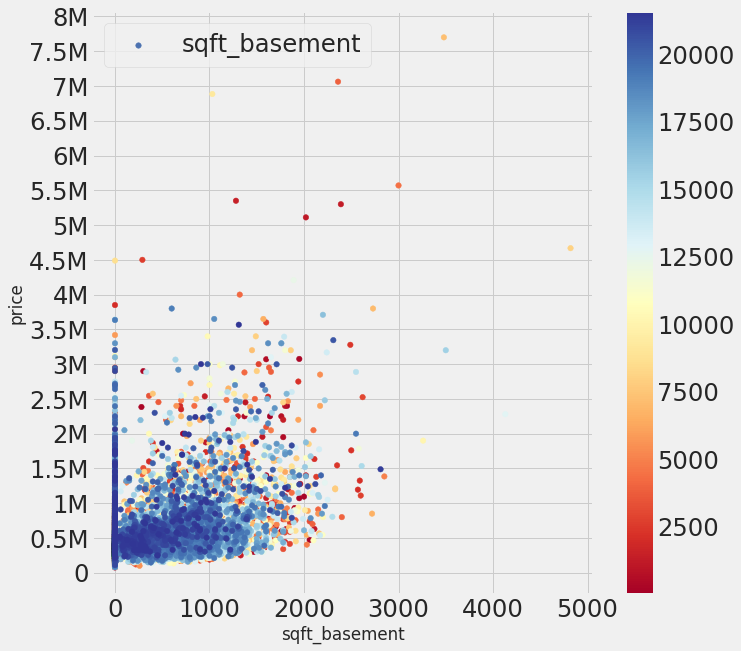

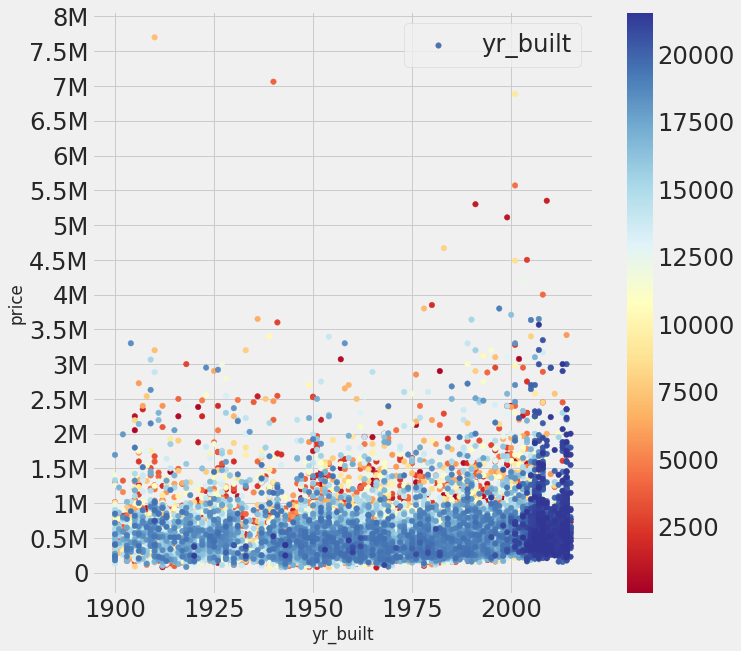

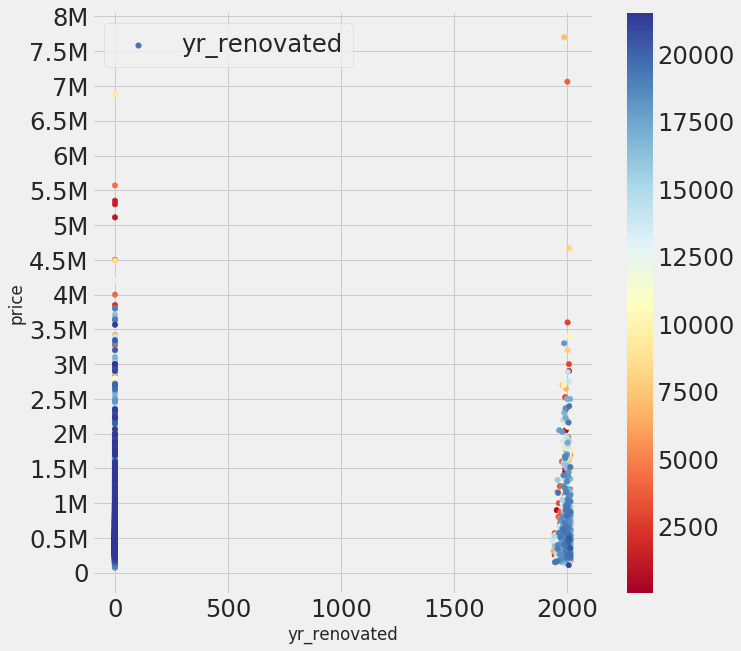

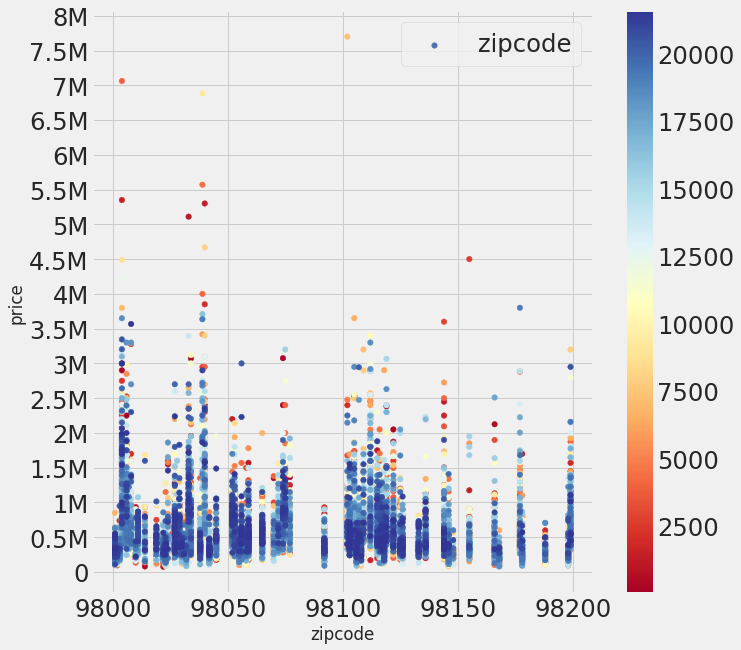

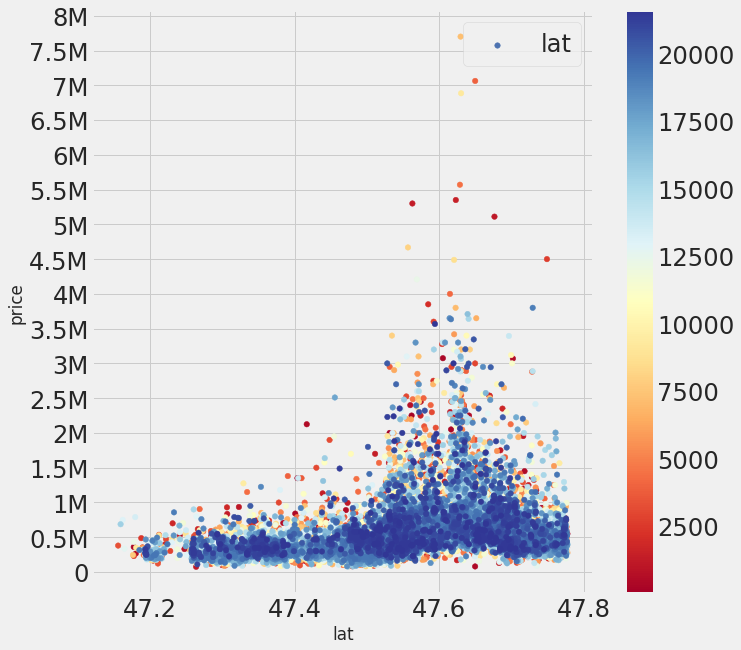

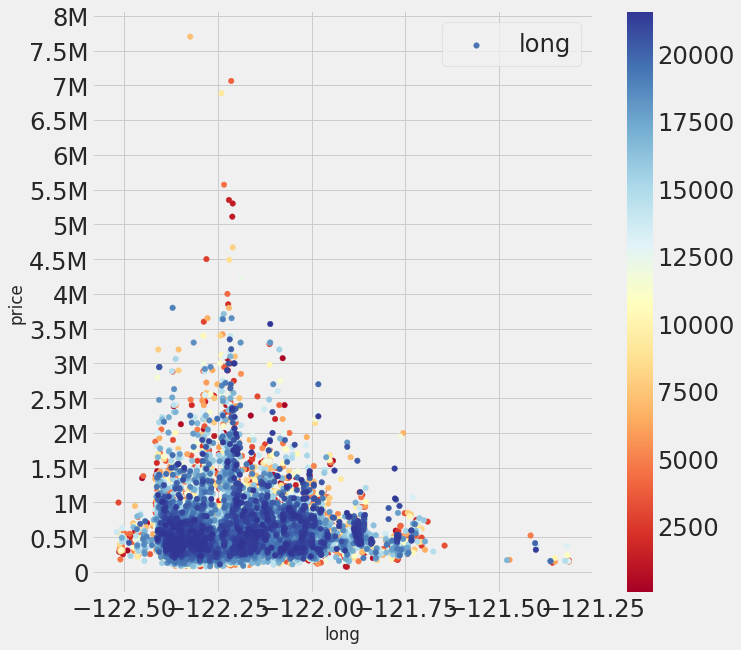

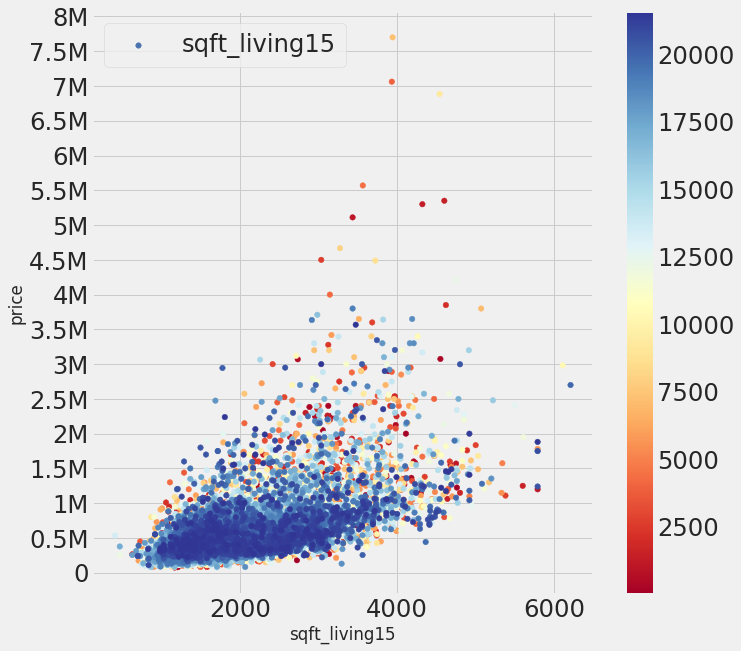

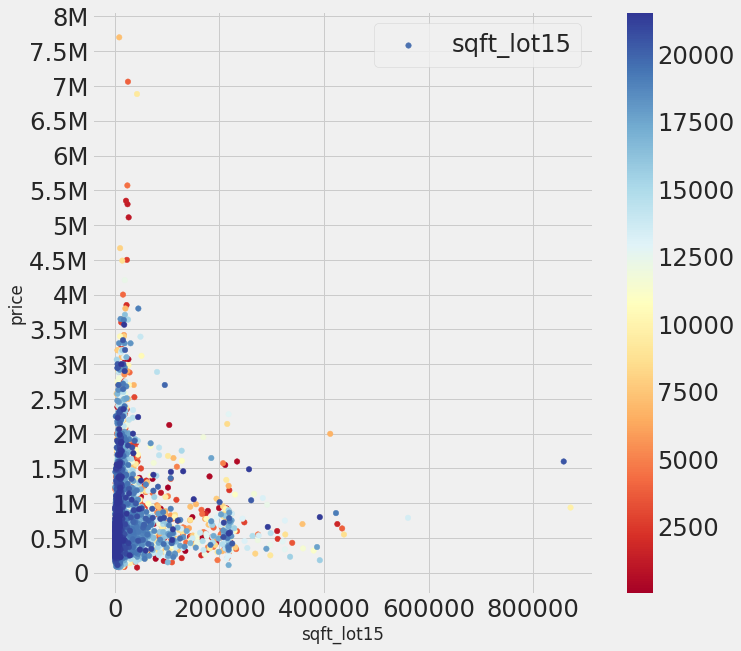

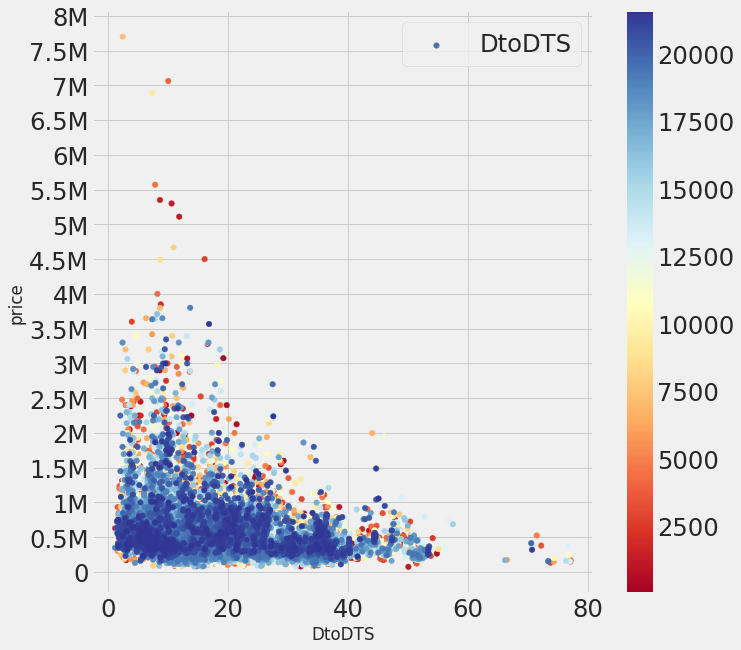

In [32]:
style.use('fivethirtyeight')
cm = plt.cm.get_cmap('RdYlBu')
xy = range(1,21600)
z = xy
for feature in feature_matrix_unscaled:
    sc = plt.scatter(kc_df[feature], kc_df['price'], label = feature, c = z, marker = 'o', s = 30, cmap = cm)
    plt.colorbar(sc)
    plt.xlabel(''+feature)
    plt.ylabel('price')
    plt.yticks([0, 500000, 1000000, 1500000, 2000000, 2500000, 3000000, 3500000, 4000000, 4500000, 5000000, 5500000, 6000000, 6500000, 7000000, 7500000, 8000000],
            ['0', '0.5M', '1M', '1.5M', '2M', '2.5M', '3M',  '3.5M', '4M', '4.5M', '5M', '5.5M', '6M', '6.5M', '7M', '7.5M', '8M',])
    plt.legend()
    # plt.rcParams["figure.figsize"] = [10, 10]
    plt.show()

#Linear regression

In [33]:
my_linear = LinearRegression()
my_linear.fit(feature_matrix, lable_vector)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [34]:
# printing Theta0 using attribute "intercept_":
print(my_linear.intercept_)

# printing [Theta1, Theta2, Theta3] using attribute "coef_":
print(my_linear.coef_)
coef_list = my_linear.coef_
print(coef_list)

95762914.17184299
[-3.78438937e+04  3.47694204e+04  1.12708449e+02  2.19030318e-01
 -2.02368002e+04  6.00842474e+05  5.47384410e+04  2.85341730e+04
  8.24225586e+04  8.66183733e+01  2.60900753e+01 -1.77610387e+03
  2.45341219e+01 -7.40494989e+02  1.65247909e+05  2.27663439e+05
  1.50938997e+01 -8.74762191e-02 -1.21010531e+04]
[-3.78438937e+04  3.47694204e+04  1.12708449e+02  2.19030318e-01
 -2.02368002e+04  6.00842474e+05  5.47384410e+04  2.85341730e+04
  8.24225586e+04  8.66183733e+01  2.60900753e+01 -1.77610387e+03
  2.45341219e+01 -7.40494989e+02  1.65247909e+05  2.27663439e+05
  1.50938997e+01 -8.74762191e-02 -1.21010531e+04]


### Sorting features based on co-efficient values from linear regression.


In [35]:
feature_dict = dict(zip(features, coef_list))

import operator
sorted_d = sorted(feature_dict.items(), key=operator.itemgetter(1),reverse=True)
print('Dictionary in descending order by value : ',sorted_d)

Dictionary in descending order by value :  [('waterfront', 600842.4741845292), ('long', 227663.4394422104), ('lat', 165247.9094939908), ('grade', 82422.55862680211), ('view', 54738.44101399997), ('bathrooms', 34769.420360394906), ('condition', 28534.173043001334), ('sqft_living', 112.70844873830602), ('sqft_above', 86.61837334936457), ('sqft_basement', 26.090075287135242), ('yr_renovated', 24.53412186552201), ('sqft_living15', 15.09389973023133), ('sqft_lot', 0.21903031825629005), ('sqft_lot15', -0.08747621914881165), ('zipcode', -740.4949885106524), ('yr_built', -1776.1038710288028), ('DtoDTS', -12101.053097820219), ('floors', -20236.800229483182), ('bedrooms', -37843.89373257139)]


### Checking best features vs price using pairplot.

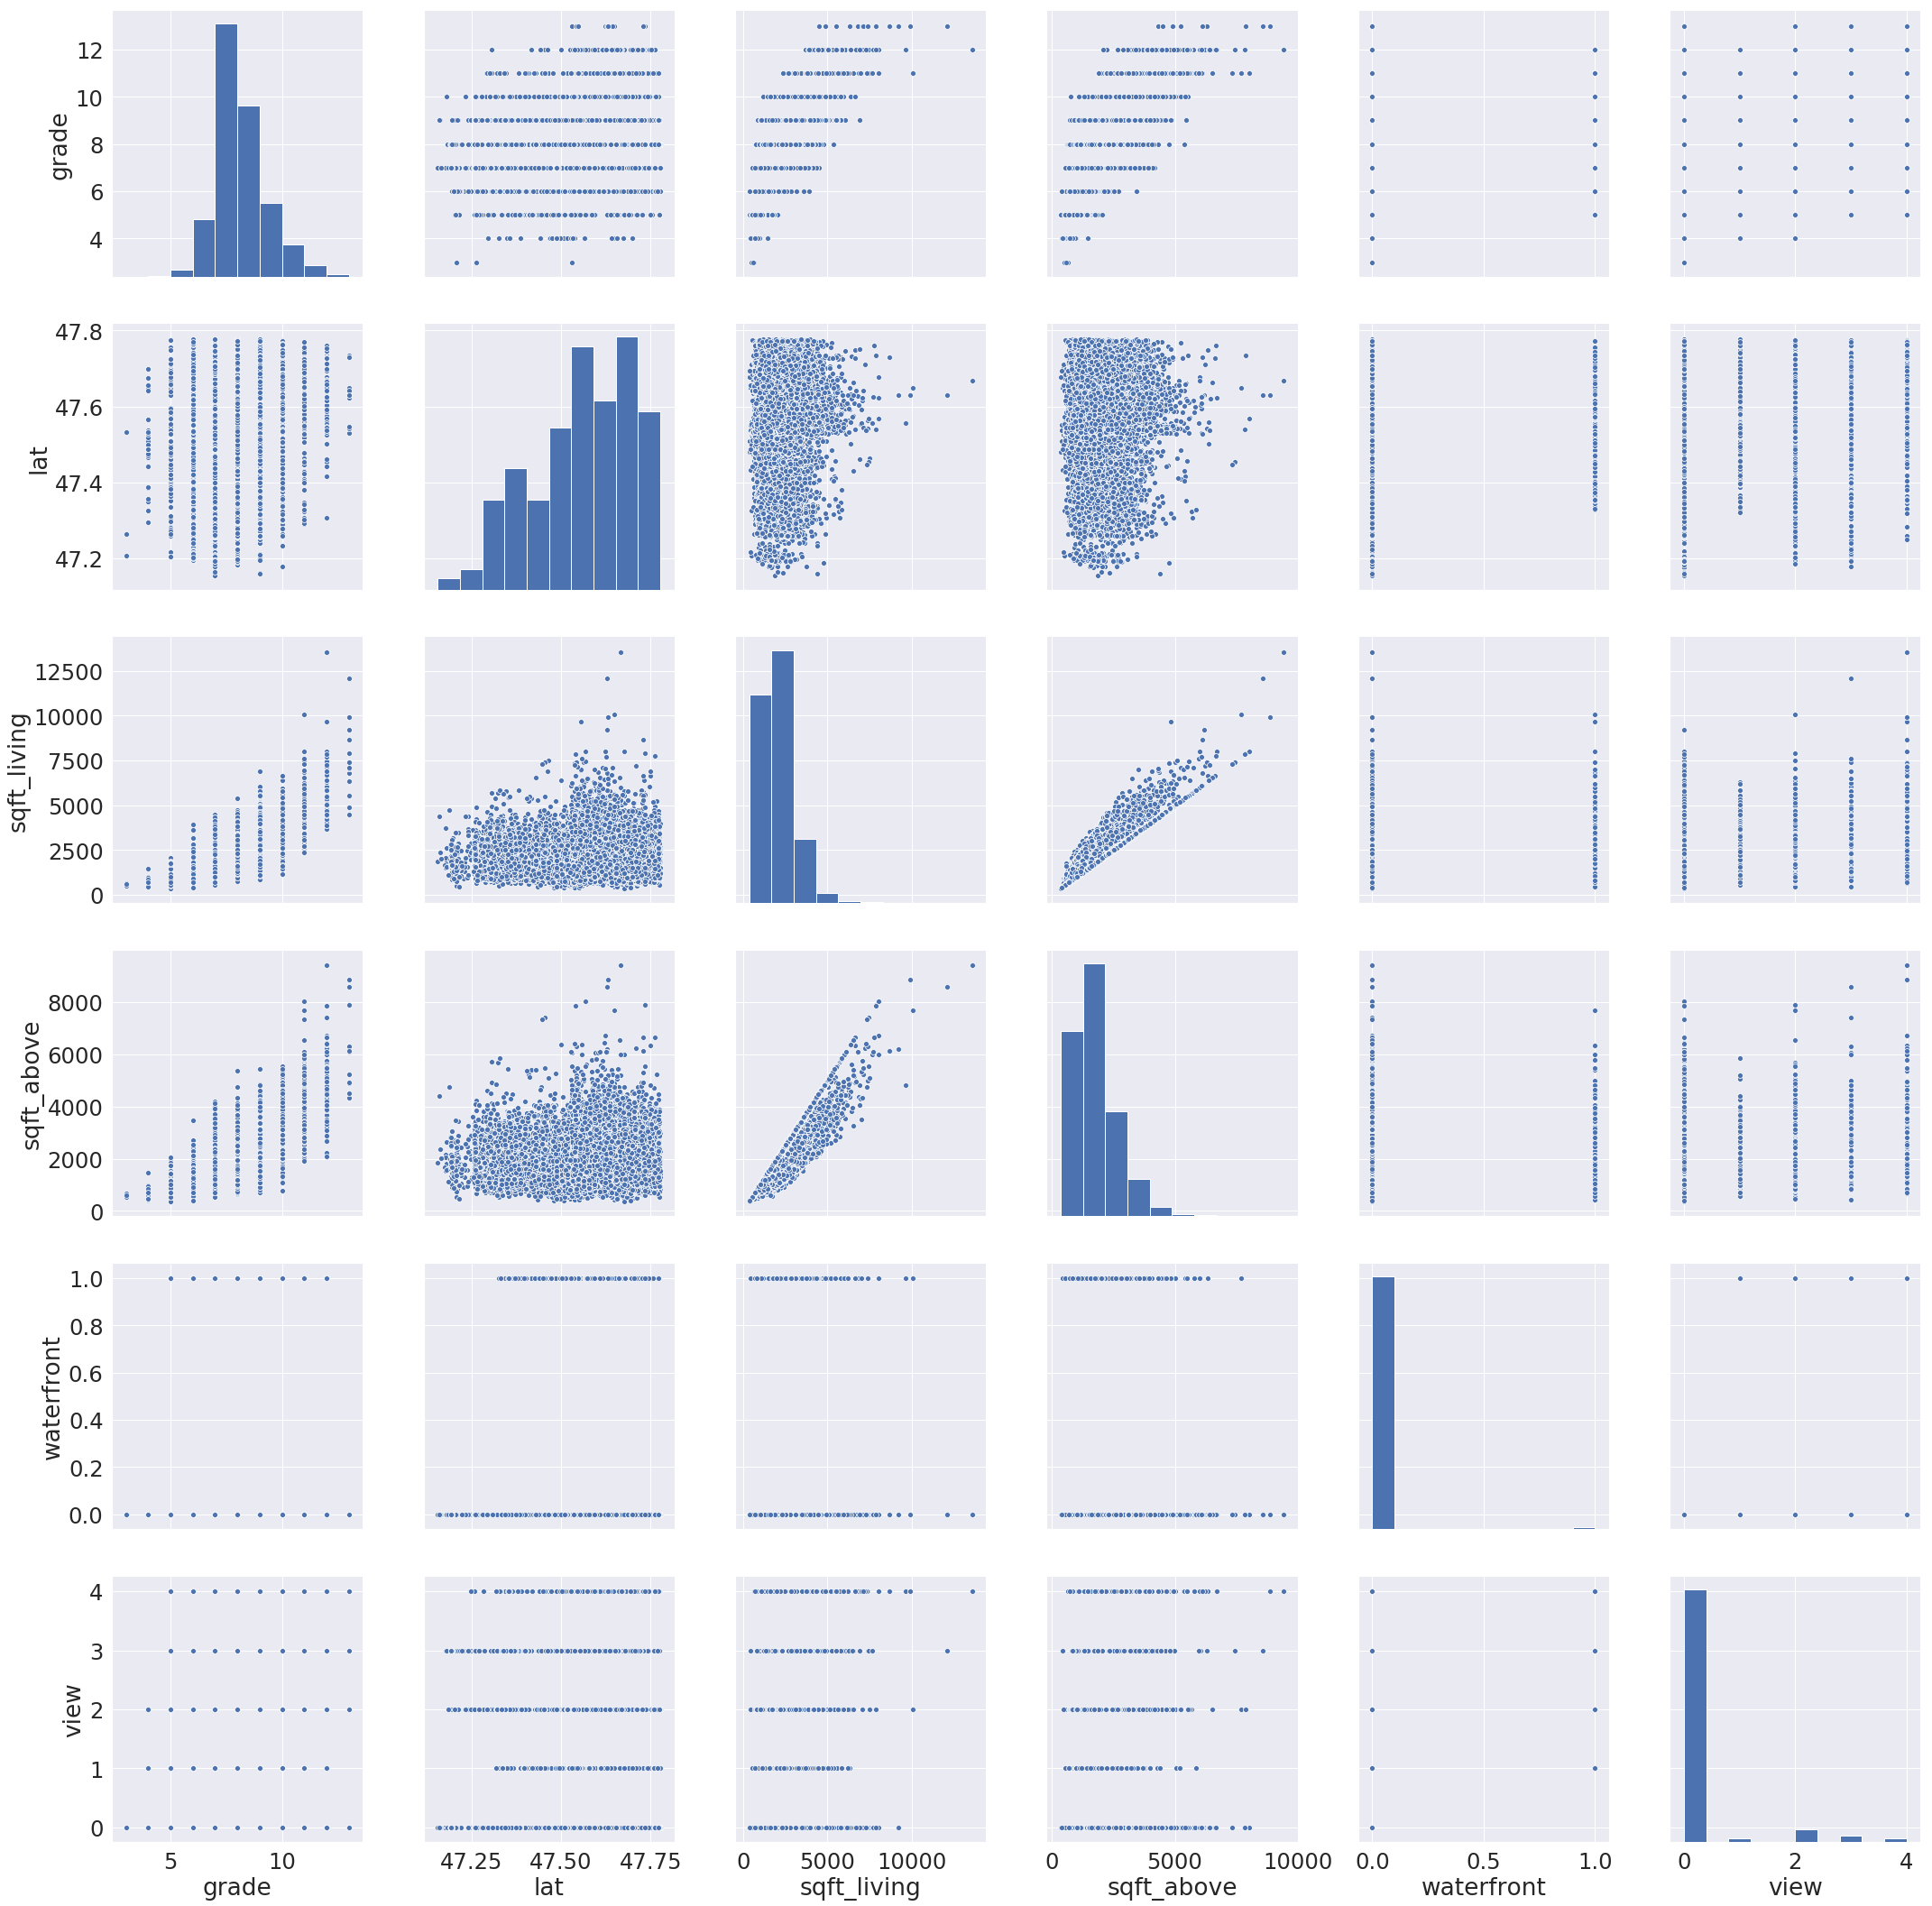

In [37]:
sorted_features = ['grade','lat','sqft_living','sqft_above','waterfront','view']
sns.set(font_scale=2.2)
g = sns.pairplot(kc_df[sorted_features] ,height=5)
plt.show()

In [38]:
sorted_features = ['grade','lat','sqft_living','sqft_above','waterfront','view']
best_feature_matrix = kc_df[sorted_features]

#scaling deature
X_train, X_test, y_train, y_test = train_test_split(best_feature_matrix, lable_vector, test_size=0.3, random_state=3)
my_linear.fit(X_train, y_train)
y_predict_ln = my_linear.predict(X_test)
print(y_predict_ln)

[261687.58016779 392218.29612611 133941.92948556 ... 491064.82761705
 479934.99932264 576099.20875895]


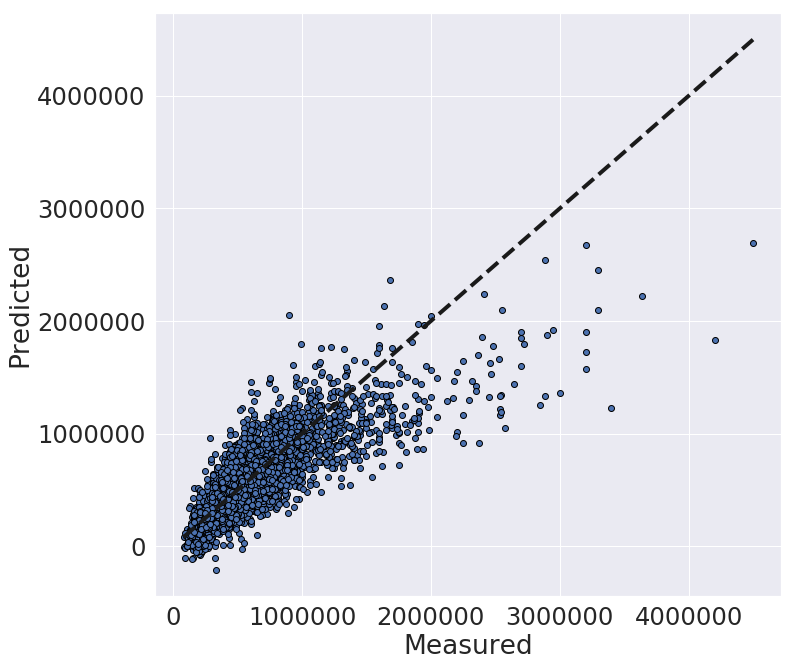

In [39]:
y_predict_ln = my_linear.predict(X_test)
fig, ax = plt.subplots()
ax.scatter(y_test, y_predict_ln, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

# Check accuracy by comparing different algorithms

### Linear regression

In [41]:
error = mean_squared_error(y_test, y_predict_ln)
root_mean_square_error = np.sqrt(error)
print("RMSE for liner regression>>>",root_mean_square_error)

RMSE for liner regression>>> 203688.03264671008


### KNN

In [42]:
k = 25
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)
y_predict_knn = knn.predict(X_test)
score_knn = accuracy_score(y_test, y_predict_knn)
print("KNN accuracy>>>>",score_knn)

KNN accuracy>>>> 0.0049382716049382715


### Decision Tree

In [43]:
my_decisiontree = DecisionTreeClassifier()
my_decisiontree.fit(X_train, y_train)
y_predict_dt = my_decisiontree.predict(X_test)
score_dt= accuracy_score(y_test, y_predict_dt)
print("Decision tree accuracy>>>>",score_dt)

Decision tree accuracy>>>> 0.009104938271604938


### Cross validation

In [44]:
kc_linear_reg = LinearRegression()
new_feature_marrix = preprocessing.scale(feature_matrix)
kc_mse = cross_val_score(kc_linear_reg,new_feature_marrix,lable_vector, cv=10, scoring='neg_mean_squared_error')


house_mse_positive = -kc_mse

house_rmse = np.sqrt(house_mse_positive)

print("RMSE for cross validation>>>",house_rmse.mean())

RMSE for cross validation>>> 190427.9446577416


### Random Forest

In [45]:
my_RandomForest = RandomForestClassifier(n_estimators = 10, bootstrap = True, random_state=2)
my_RandomForest.fit(X_train,y_train) #train random forest classifier using training data
y_predict_rf=my_RandomForest.predict(X_test) #predict using testing data
score_rf=accuracy_score(y_test, y_predict_rf) #accuracy based on predicted values and original values
print("Accuracy for Random Forest>>>>> ",score_rf)

Accuracy for Random Forest>>>>>  0.008796296296296297


### PCA

In [47]:
n=6
my_pca = PCA(n_components=n)
feature_matrix_scaled = preprocessing.scale(feature_matrix)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(feature_matrix_scaled, lable_vector, test_size=0.3, random_state=3)
X_Train_new = my_pca.fit_transform(X_train_pca)
X_Test_new = my_pca.transform(X_test_pca)
print(X_Test_new.shape)

(6480, 6)


In [48]:
my_linear = LinearRegression()
my_linear.fit(X_Train_new, y_train_pca)
y_predict_ln = my_linear.predict(X_Test_new)#score_lr = accuracy_score(y_test, y_predict_ln)
error = mean_squared_error(y_test_pca, y_predict_ln) 
root_mean_square_error = np.sqrt(error) 
print("RMSE for PCA>>>>>>>",root_mean_square_error)

RMSE for PCA>>>>>>> 207391.92504957883


### Coefficient of determination

In [51]:
kc_df['year_sell'] = [int(i[:4]) for i in kc_df.date]

kc_df.year_sell.value_counts().sort_index()


#test=kc_df[kc_df.year_sell==2015].reset_index(drop=True )
train=kc_df[kc_df.year_sell==2014].reset_index(drop=True )
x=train[kc_df.columns.drop(['price','date'])]
y=train['price']
col=kc_df.columns.drop(['price','date'])
clf = LinearRegression()
clf.fit(x,y)
score_dt = clf.score(x,y)
print("Determination>>>>>>",score_dt)

Determination>>>>>> 0.7390020183319268


### Adding features by taking square of each feature.

In [52]:

df_kc_square = pd.DataFrame()
for feature in features:
    df_kc_square[feature + '_square'] = kc_df[feature]*kc_df[feature]
print(df_kc_square.shape)

(21599, 19)


In [53]:
square_df = pd.concat([feature_matrix_unscaled, df_kc_square], axis=1)
square_df.shape

(21599, 38)

In [56]:
# normalize data
scaled_square_df = preprocessing.scale(square_df)
scaled_square_df

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


array([[-0.41073995, -1.45002513, -0.98034594, ..., -0.7888722 ,
        -0.08965596, -0.60117763],
       [-0.41073995,  0.17476309,  0.53350007, ..., -0.46959964,
        -0.08694689, -0.59283131],
       [-1.5163696 , -1.45002513, -1.42687606, ...,  0.89789847,
        -0.08626618, -0.3867495 ],
       ...,
       [-1.5163696 , -1.77498278, -1.1546016 , ..., -1.01623159,
        -0.09251494, -0.87922676],
       [-0.41073995,  0.49972074, -0.52292484, ..., -0.73091843,
        -0.09275802,  0.00575932],
       [-1.5163696 , -1.77498278, -1.1546016 , ..., -1.01623159,
        -0.09273905, -0.87900968]])

### PCA on squared data

In [57]:
n=7
my_pca = PCA(n_components=n)
X_train_square, X_test_square, y_train_square, y_test_square = train_test_split(scaled_square_df, lable_vector, test_size=0.3, random_state=3)
X_Train_new = my_pca.fit_transform(X_train_square)
X_Test_new = my_pca.transform(X_test_square)
my_linear_squared = LinearRegression()
my_linear_squared.fit(X_Train_new, y_train_square)
y_predict_sq = my_linear_squared.predict(X_Test_new)#score_lr = accuracy_score(y_test, y_predict_ln)
error = mean_squared_error(y_test_square, y_predict_sq) 
root_mean_square_error = np.sqrt(error) 
print("RMSE for squared PCA>>>>>>>",root_mean_square_error)

RMSE for squared PCA>>>>>>> 187345.144004419


### Cross validation on squared data

In [58]:
kc_linear_reg_square = LinearRegression()
kc_mse = cross_val_score(kc_linear_reg,scaled_square_df,lable_vector, cv=10, scoring='neg_mean_squared_error')


house_mse_positive = -kc_mse

house_rmse = np.sqrt(house_mse_positive)

print("RMSE for squared cross validation>>>",house_rmse.mean())

RMSE for squared cross validation>>> 170399.27173225774


# Polynomial Regression

In [59]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)
#print(X_train_poly.shape)
poly_lin_reg = LinearRegression()
poly_lin_reg.fit(X_train_poly, y_train)
y_predict_poly = poly_lin_reg.predict(X_test_poly)
print(y_predict_poly)

[368437.68710423 449566.26690388 331928.52348709 ... 453131.96929932
 473263.76604939 523575.01441765]


In [60]:
error = mean_squared_error(y_predict_poly, y_test)
#print(error)
root_mean_square_error = np.sqrt(error)
print("RMSE for polynomial regression>>>>>>>>",root_mean_square_error)

RMSE for polynomial regression>>>>>>>> 184111.2215927154


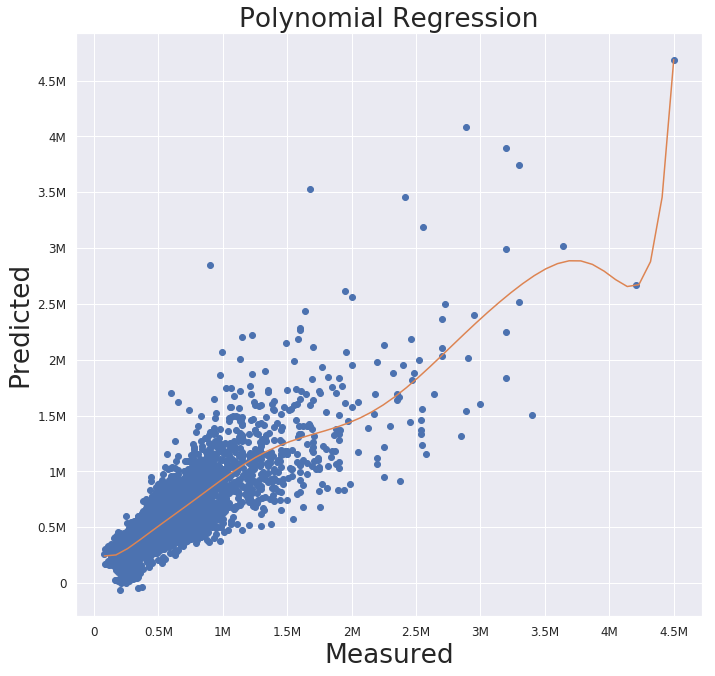

In [61]:
z = np.polyfit(y_test,y_predict_poly,10) 

p = np.poly1d(z)

plt.title ('Polynomial Regression')
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.yticks([0, 500000, 1000000, 1500000, 2000000, 2500000, 3000000, 3500000, 4000000, 4500000, 5000000, 5500000, 6000000, 6500000, 7000000, 7500000, 8000000],
            ['0', '0.5M', '1M', '1.5M', '2M', '2.5M', '3M',  '3.5M', '4M', '4.5M', '5M', '5.5M', '6M', '6.5M', '7M', '7.5M', '8M'], fontsize = 12)
plt.xticks([0, 500000, 1000000, 1500000, 2000000, 2500000, 3000000, 3500000, 4000000, 4500000, 5000000, 5500000, 6000000, 6500000, 7000000, 7500000, 8000000],
            ['0', '0.5M', '1M', '1.5M', '2M', '2.5M', '3M',  '3.5M', '4M', '4.5M', '5M', '5.5M', '6M', '6.5M', '7M', '7.5M', '8M'], fontsize = 12)
    

#plt.plot(y_test[:100], y_predict_poly[:100],'o-')
#plt.plot(y_test[:5], y_predict_poly[:5], '-')

datax_os = np.linspace(y_test.min(), y_test.max(), 50)
#plt.figure(figsize=(18,18))
plt.plot(y_test, y_predict_poly, 'o',datax_os, p(datax_os) ) # 'smoother' line

plt.show()